In [1]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [2]:
import os
if  not 'juxtorpus' in os.listdir():
    os.chdir('../../')
assert 'juxtorpus' in os.listdir(), f"Working directory should be at juxtorpus. But at {os.getcwd()}"
f"Working directory: {os.getcwd()}"

# imports
import pandas as pd
from pathlib import Path
import spacy
from juxtorpus.corpus import Corpus
from juxtorpus.corpus.processors import process
from juxtorpus.corpus.app import App
from juxtorpus.corpus.topic_model import LDA
from juxtorpus.viz.corpus import timeline, timelines, wordcloud, wordclouds
from juxtorpus.viz.item_timeline import ItemTimeline
from juxtorpus.matchers import is_hashtag

from juxtorpus import Jux
from juxtorpus.corpus.corpora import Corpora

import warnings
warnings.filterwarnings('ignore')


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# Juxtorpus
## A fast demo on binderhub @ AARNet

# 1. Build a Corpus (Auspol Tweets dataset)

In [3]:
use_cols = ['id', 'created_at', 'source', 'location', 'text', 'retweet_count', 'lang', 'possibly_sensitive', 'tweet_type']
dtypes = ['Int64', 'category', 'string', 'Int64', 'category', 'category', 'category']

df = pd.read_csv(Path('./notebooks/demos/Sample_Auspol_Tweets_Full.csv'), 
                 usecols=use_cols, 
                 dtype={'id': 'Int64', 'source': 'category', 'location':str, 'text':str, 'retweet_count':int, 'lang': 'category', 'tweet_type': 'category'})
df['created_at'] = pd.to_datetime(df['created_at'])
corpus = process(Corpus.from_dataframe(df, col_doc='text', name='auspol'), nlp=spacy.blank('en'))
corpus.name

'auspol'

In [4]:
corpora = Corpora([corpus])
# corpora.add(corpus)   # alternatively
corpora.widget()

In [5]:
df.columns

Index(['id', 'created_at', 'source', 'location', 'text', 'retweet_count',
       'lang', 'possibly_sensitive', 'tweet_type'],
      dtype='object')

## Exploring the Corpus

In [6]:
corpus = corpora['auspol']
print('This table summarise the basic information of the corpus')
corpus.summary()

This table summarise the basic information of the corpus


Corpus Type                                                    SpacyCorpus
Number of Documents                                                 100000
Number of Total Words                                              1544294
Size of Vocabulary                                                   40469
mean Words per Document                                                 15
min Words per Document                                                   0
max Words per Document                                                  59
metas                    id, created_at, source, location, retweet_coun...

### Corpus Wordcloud

Generate a word cloud with one line of code


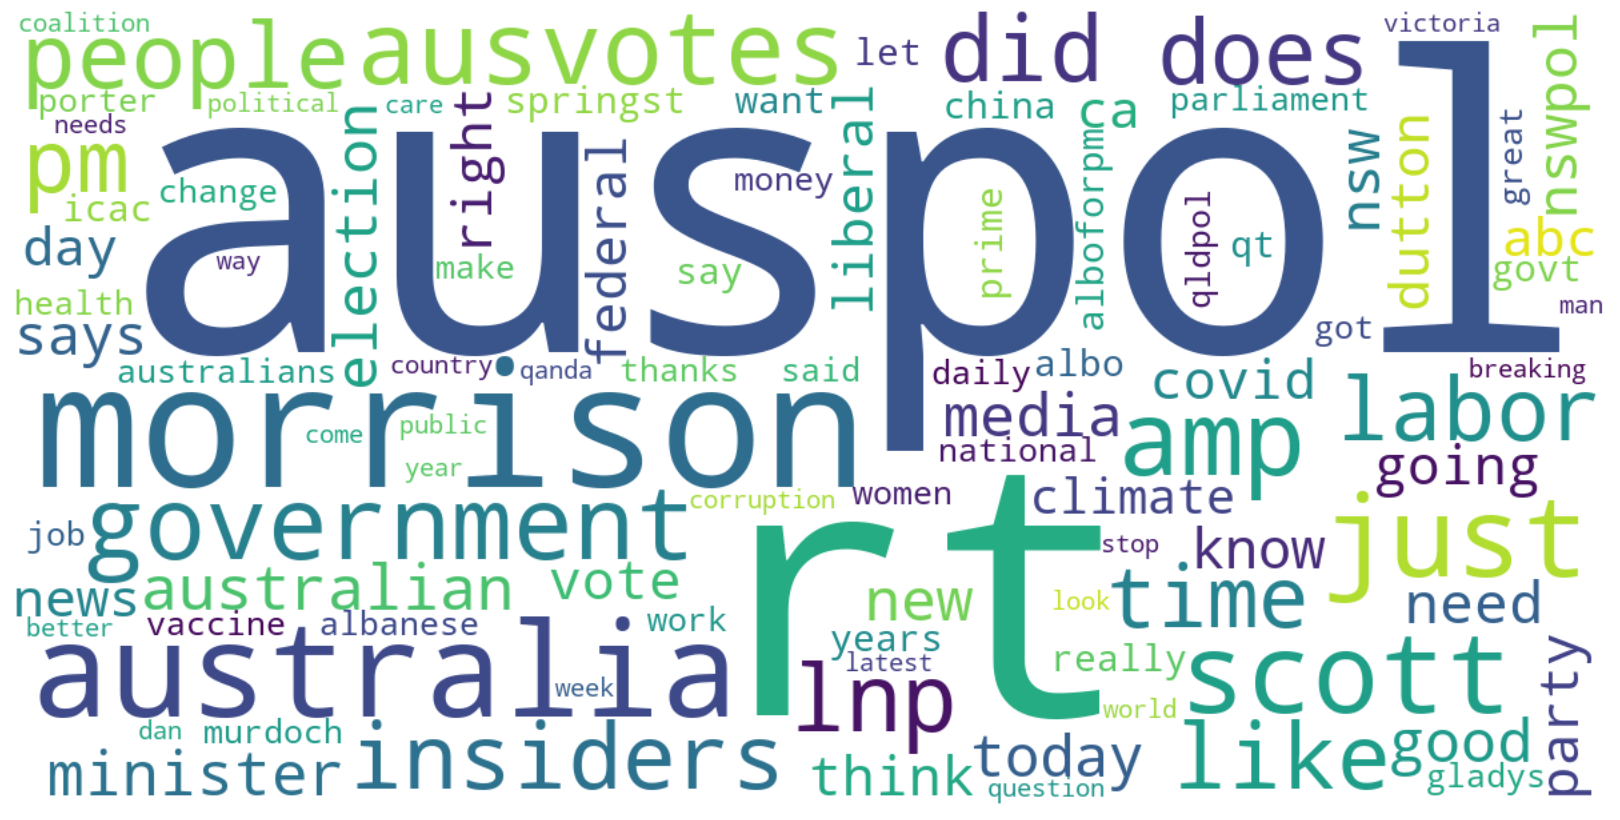

In [7]:
MAX_WORDS = 100
TYPE = 'word'
# TYPE = 'hashtag'
# TYPE = 'mention'
print('Generate a word cloud with one line of code')
corpus.viz.wordcloud(max_words=MAX_WORDS, word_type=TYPE)

Or make a wordcloud focusing on another predefined pattern - Hashtag


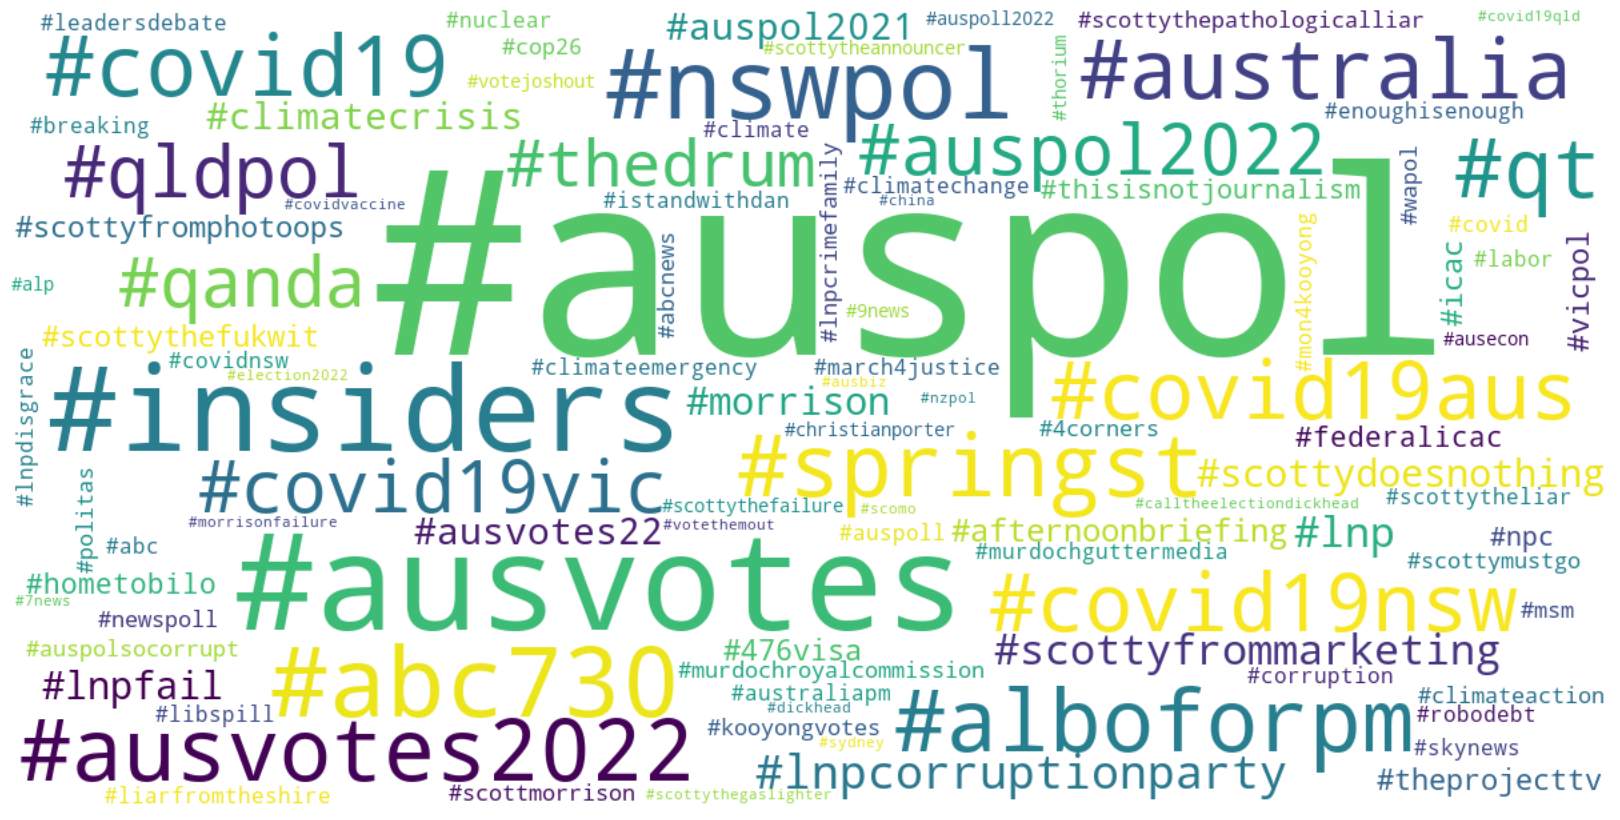

In [8]:
MAX_WORDS = 100
# TYPE = 'word'
TYPE = 'hashtag'
# TYPE = 'mention'
print('Or make a wordcloud focusing on another predefined pattern - Hashtag')
corpus.viz.wordcloud(max_words=MAX_WORDS, word_type=TYPE)

### A Timeline of Daily Tweets Number

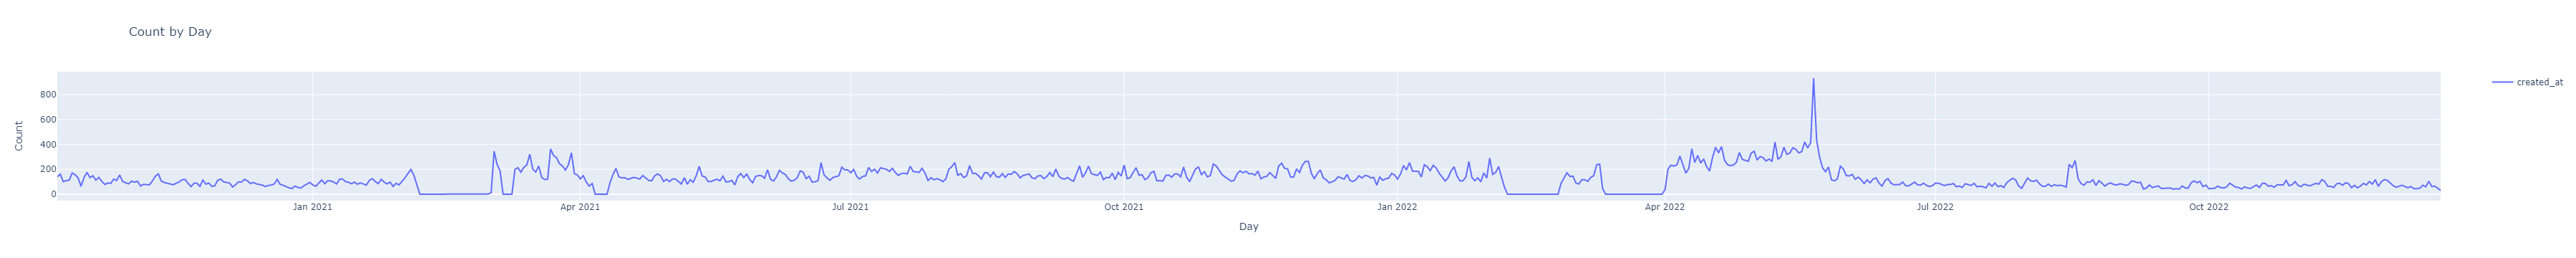

In [9]:
# FREQ = '1w'
# FREQ = '1m'
FREQ = '1d'
COL_TIME = 'created_at'
corpus.viz.timeline(COL_TIME, freq=FREQ)

Can also aggregate the data by different periods, e.g. weekly tweeting numbers


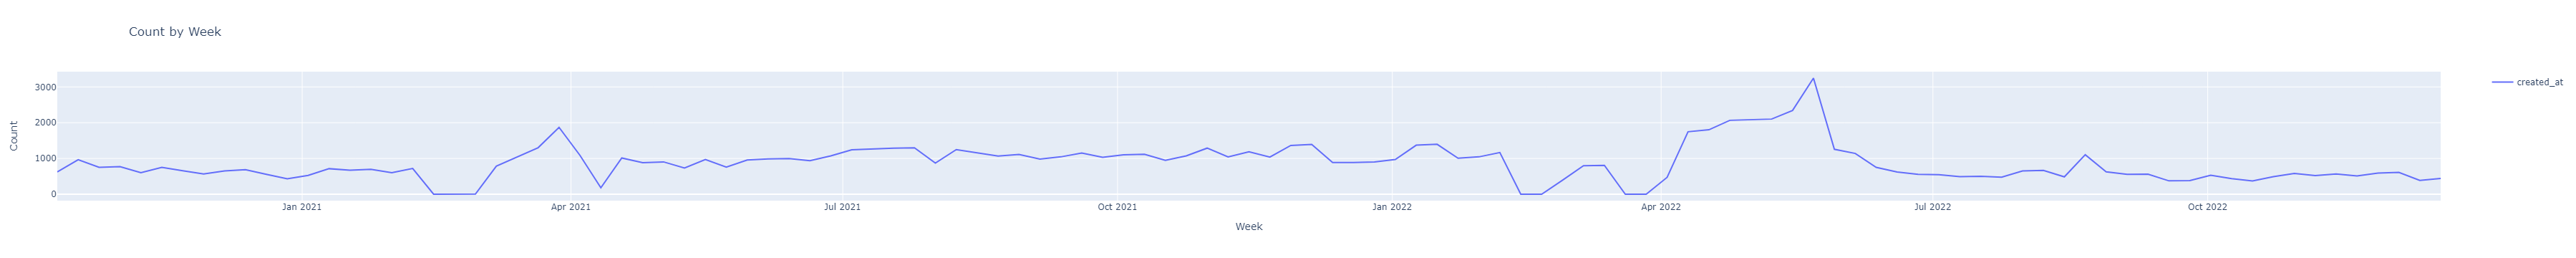

In [10]:
print('Can also aggregate the data by different periods, e.g. weekly tweeting numbers')
corpus.viz.timeline(COL_TIME, freq='1w')

In [11]:
COL_TIME = 'created_at'
FREQ = '1w'

# user defined function in creating a custom dtm (document-term-matrix)
matcher = is_hashtag(corpus.nlp.vocab)
def extract_hashtags(doc): return [doc[s:e].text.lower() for _, s, e in matcher(doc)]
corpus.create_custom_dtm(extract_hashtags)

print('Extract all Hashtags and display their weekly trends\n - Click legend to deselect items\n - Use the search box to display specific hashtag')
item_timeline = ItemTimeline.from_corpus(corpus, COL_TIME, FREQ, custom_dtm=True)
item_timeline.render()

Extract all Hashtags and display their weekly trends
 - Click legend to deselect items
 - Use the search box to display specific hashtag


FigureWidget({
    'data': [{'marker': {'color': 'rgba(136,244,0,1.0)'},
              'mode': 'lines+markers+…

# Corpus Slicer - creating a subcorpus

## Slice the corpus by categorical metadata - Single or Multiple Choices

In [12]:
temp_corpus = corpora['auspol'].slicer.filter_by_item('lang', 'en')
temp_corpus.name = 'auspol-en'
corpora.add(temp_corpus)
#
temp_corpus = corpora['auspol-en'].slicer.filter_by_item('source', ['Twitter for iPad', 'Twitter for iPhone', 'Twitter for Mac'])
temp_corpus.name = 'Apple'
corpora.add(temp_corpus)

## Slice the corpus by time

In [13]:
temp_corpus = corpora['auspol-en'].slicer.filter_by_datetime('created_at', start='01/03/2022', end='01/06/2022')
temp_corpus.name = 'Autumn22'
corpora.add(temp_corpus)
#
temp_corpus = corpora['auspol-en'].slicer.filter_by_datetime('created_at', start='01/09/2021', end='01/12/2021')
temp_corpus.name = 'Spring21'
corpora.add(temp_corpus)

## Slice the corpus by conditions, customised functions or slice the sub-corpora


In [14]:
import re
temp_corpus = corpora['auspol-en'].slicer.filter_by_condition('retweet_count', lambda cnt: cnt>3)
temp_corpus.name = 'rt5+'
corpora.add(temp_corpus)
#
L_func = '''lambda x: re.match(r'^.*android.*$', x, re.IGNORECASE) is not None'''
temp_corpus = corpora['auspol-en'].slicer.filter_by_condition('source', eval(L_func))
temp_corpus.name = 'Android'
corpora.add(temp_corpus)

## Interactive Widget for Slicing the Corpora

In [15]:
corpora.widget()

# Text Analysis on Corpus

### All exploration can be easily repeated on sub-corpus, e.g. Wordcloud

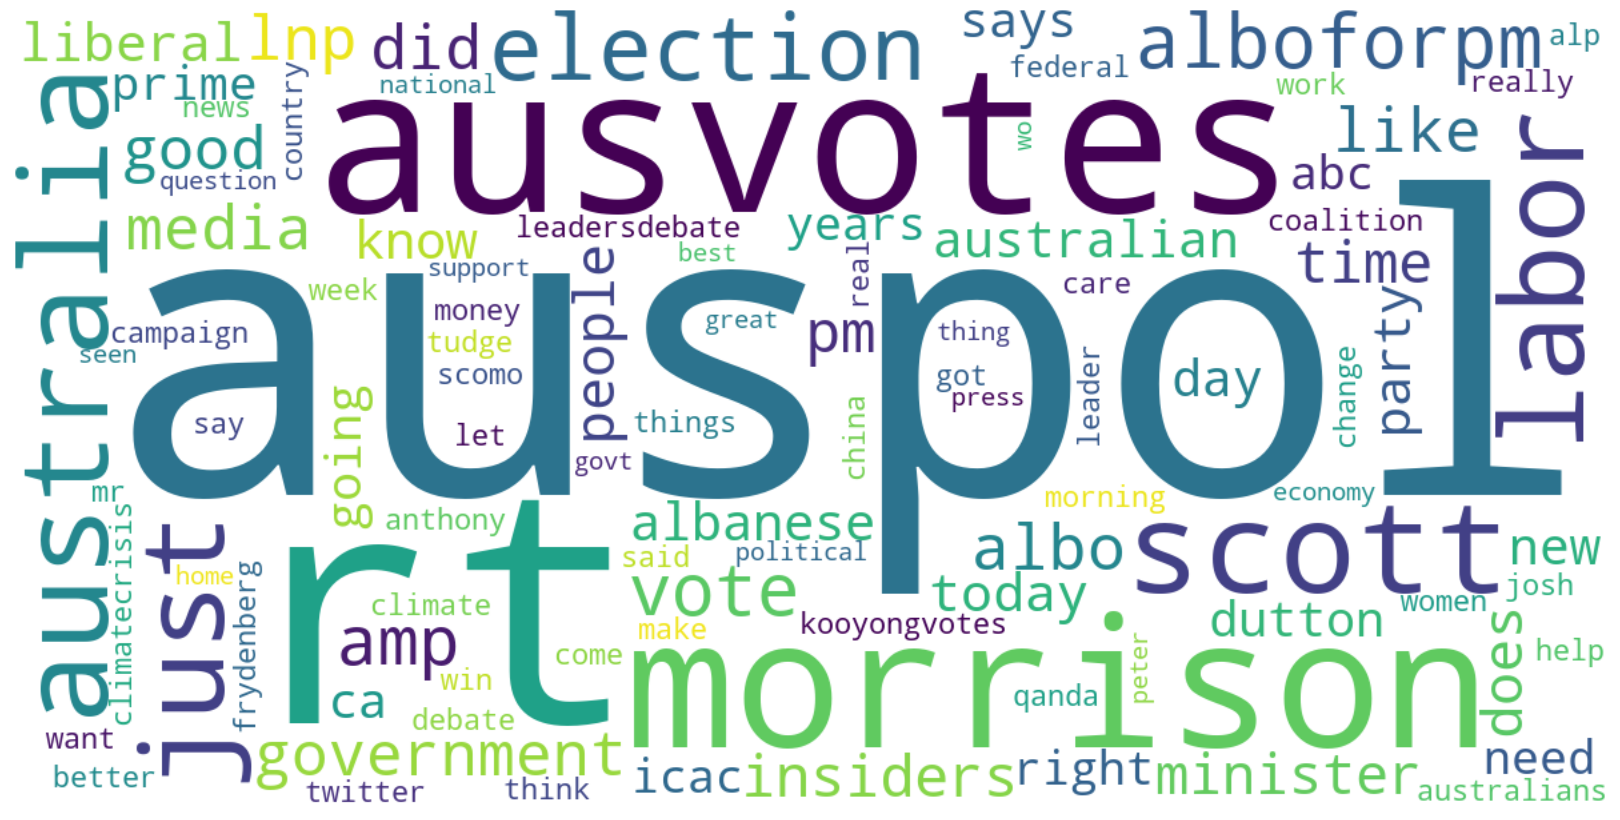

In [16]:
corpora['Autumn22'].viz.wordcloud(max_words=MAX_WORDS, word_type='word')

# Closing

+ Release is planned tentatively in **May**.
+ Full-length notebook available at https://dev-binderhub.atap-binder.cloud.edu.au/v2/gh/alex-ip/juxtorpus/alex-ip-live-demo?labpath=notebooks%2Fdemos%2FDemo-AARNet.ipynb
+ We will eventually integrate the ATAP tools together so you can easily access it under Corpus.
+ Stay tuned at https://www.atap.edu.au/
+ Feedback Survey at the end of the full workshop.
+ Questions - I'll be around or email me at huen.chan@sydney.edu.au